
# mrbles pipeline example

## Load necessary modules

In [1]:
# Dataframe modules
import numpy as np
import pandas as pd
import xarray as xr

# Import the mrbles package
import mrbles

# Regular plot graphs
import matplotlib.pyplot as plt
%matplotlib inline

# For fancy interactive Plotly graphs
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tools
from plotly.tools import FigureFactory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # For plotly offline mode
init_notebook_mode(connected=True)

Copyright 2015-2018 - The Encoded Beads Project - ThornLab@UCSF and FordyceLab@Stanford


## Load image set

The dictionary keys of image folders and image pattersn must match.
The instatiatiation of the object will search for the files. An error is thrown if no images are found.

In [2]:
image_folders = {"A" : r"../data",
                 "B" : r"../data"
}

image_patterns = {"A" : r"peptide_biotin_streptavidin_([0-9]|[0-9][0-9])_MMStack_Pos0.ome.tif",
                  "B" : r"peptide_biotin_streptavidin_([0-9]|[0-9][0-9])_MMStack_Pos0.ome.tif"
}
mrbles_images = mrbles.Images(folders=image_folders, file_patterns=image_patterns)
mrbles_images.crop_x = slice(90, 990)
mrbles_images.crop_y = slice(90, 990)

In [3]:
mrbles_images.files

{'A': ['../data\\peptide_biotin_streptavidin_10_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_09_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_08_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_07_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_06_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_05_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_04_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_03_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_02_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_01_MMStack_Pos0.ome.tif'],
 'B': ['../data\\peptide_biotin_streptavidin_10_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_09_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_08_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_07_MMStack_Pos0.ome.tif',
  '../data\\peptide_biotin_streptavidin_06_MMStack_Pos0.ome.tif',

In [4]:
mrbles_images.load()

If no error was thrown the images can be loaded into memory.

In [5]:
mrbles_images.data['A'].c

<xarray.DataArray 'c' (c: 11)>
array(['Cy5_5%', 'Brightfield', 'l-435', 'l-474', 'l-536', 'l-546', 'l-572',
       'l-620', 'l-630', 'l-650', 'l-780'], dtype='<U11')
Coordinates:
  * c        (c) <U11 'Cy5_5%' 'Brightfield' 'l-435' 'l-474' 'l-536' 'l-546' ...

By calling the object the Xarray content is displayed.

The internal Xarray DataArray can be sliced using Xarray syntax (similar to Pandas).
```python
mrbles_images['set name', file number, 'channel name', y-slice, x-slice]
```

In [6]:
mrbles_images.rename_channel('Cy5_5%', 'Cy5')

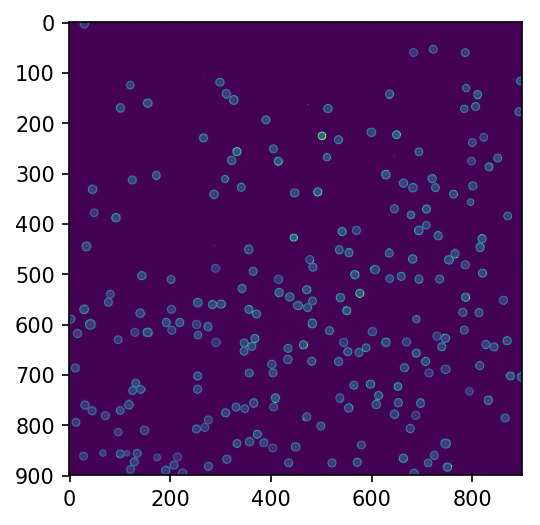

In [7]:
plt.figure(dpi=150)
plt.imshow(mrbles_images['A', 0, 'Cy5']);

## Find MRBLEs in images

Instatiate a MBRLEs finding object, giving initial bead_size (pixels), which must be set. More fine-tune settings can be set by calling object.settings.area_max etc. Otherwise, default settings are used.

In [8]:
find_mrbles = mrbles.Find(bead_size=18, border_clear=True, circle_size=350)
find_mrbles.settings.eccen_max = 0.65
find_mrbles.settings.parallelize = False

In [9]:
find_mrbles.find(mrbles_images[:, : , 'Brightfield'])

Bead radius AVG: 17.79
Bead radius SD: 0.35
Bead radius CV: 1.99%
Number of beads in set A: 827
Number of beads in set B: 827
Total number of beads: 1654


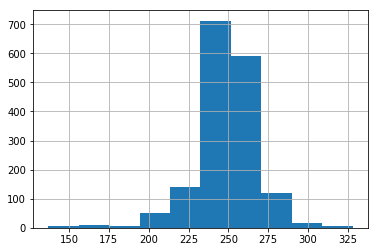

In [11]:
plt.figure(dpi=100)
find_mrbles.bead_dims.area.hist(bins=100)

In [13]:
find_mrbles['A'].c

<xarray.DataArray 'c' (c: 6)>
array(['mask_full', 'mask_ring', 'mask_inside', 'mask_outside', 'mask_bkg',
       'mask_check'], dtype='<U12')
Coordinates:
  * c        (c) <U12 'mask_full' 'mask_ring' 'mask_inside' 'mask_outside' ...

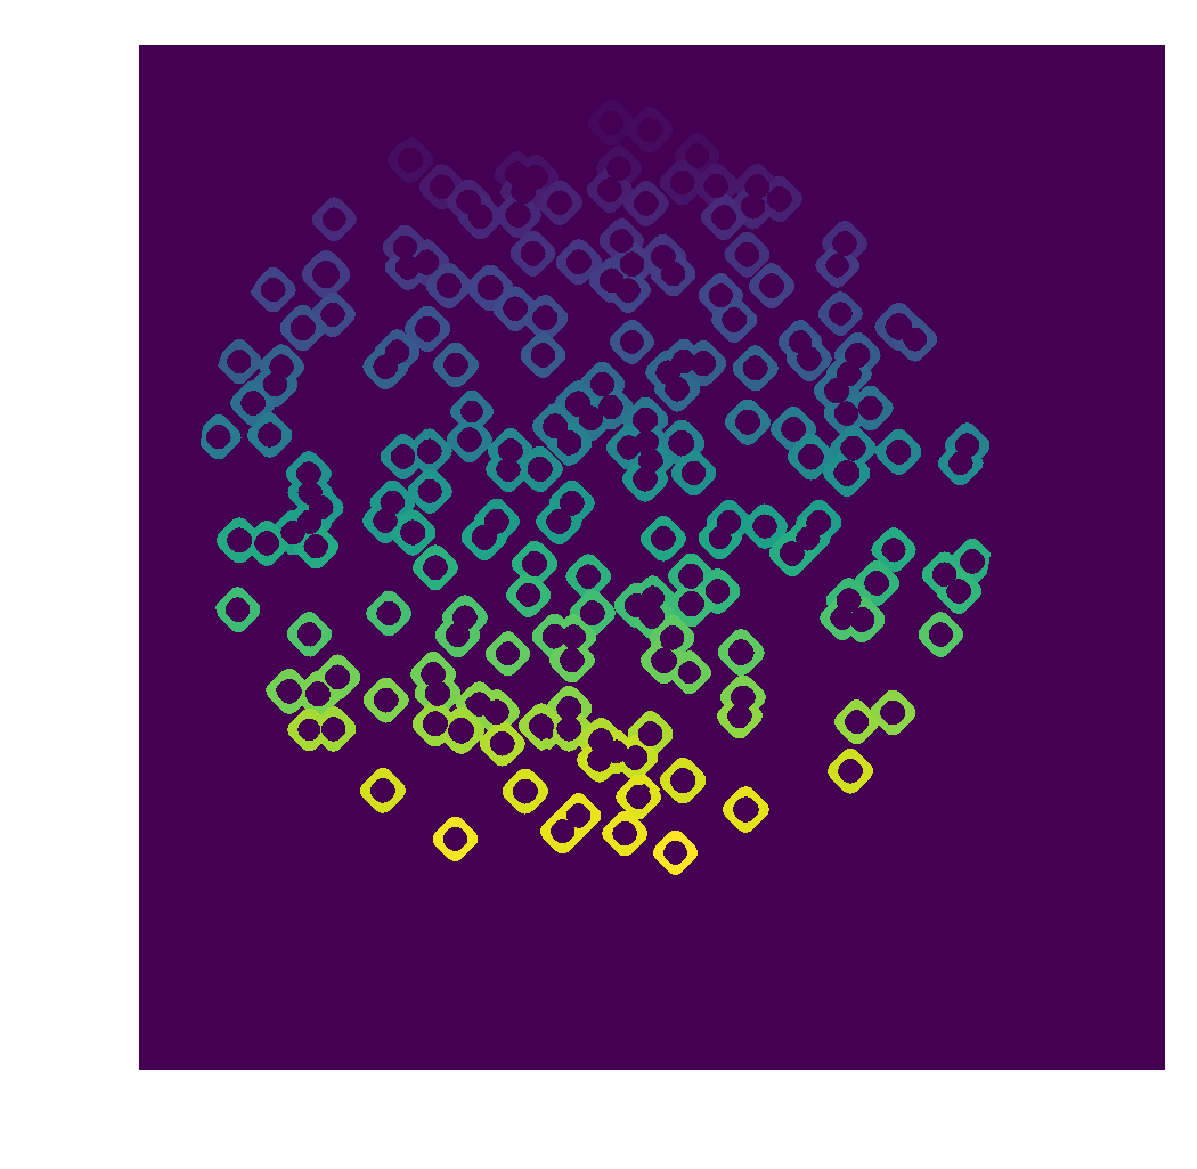

In [16]:
plt.figure(dpi=300)
plt.axis('off')
plt.tight_layout()
plt.imshow(find_mrbles['B', 1, 'mask_bkg']);

## Create Reference spectra

In [14]:
# Channel settings
DECODE_CHANNELS = slice('l-435','l-780')  # Channel range for decoding
OBJECT_CHANNEL = 'Brightfield'  # Channel for bead finding

# Reference files
REF_FOLDER = {
    "Dy": r"C:\DATA\20170406 - Reference files - KARA",
    "Sm": r"C:\DATA\20170406 - Reference files - KARA",
    "Tm": r"C:\DATA\20170406 - Reference files - KARA",
    "Eu": r"C:\DATA\20170406 - Reference files - KARA",
    "bkg": r"..\data"
}
REF_FILES = {"Dy" : "Dy_Solos_3_MMStack_Pos0.ome.tif",
             "Sm" : "Sm_solos_5_MMStack_Pos0.ome.tif",
             "Tm" : "Tm_solos_3_MMStack_Pos0.ome.tif",
             "Eu" : "Eu_solos_6_MMStack_Pos0.ome.tif",
             "bkg" : "peptide_biotin_streptavidin_03_MMStack_Pos0.ome.tif"
}

In [15]:
spec_object = mrbles.References(REF_FOLDER, REF_FILES, OBJECT_CHANNEL, DECODE_CHANNELS, bead_size=18)
spec_object.crop_x = slice(262, 762)
spec_object.crop_y = slice(262, 762)
spec_object.bkg_roi = [slice(368, 500), slice(332, 470)]

In [16]:
spec_object.load()

Bead radius AVG: 15.65
Bead radius SD: 0.84
Bead radius CV: 5.38%
Number of beads in set Dy: 270
Number of beads in set Sm: 506
Number of beads in set Tm: 308
Number of beads in set Eu: 203
Total number of beads: 1287


In [17]:
spec_object.data

,Dy,Sm,Tm,Eu,bkg
channels,,,,,
l-435,0.008394,0.016085,0.031182,0.007772,0.176903
l-474,0.399939,0.028211,0.635101,0.013283,0.227176
l-536,0.009672,0.027023,0.041902,0.024366,0.153664
l-546,0.003491,0.007325,0.013256,0.008681,0.074223
l-572,0.531328,0.109775,0.020980,0.008600,0.075409
l-620,0.000839,0.021826,0.002190,0.555858,0.056438
l-630,0.025295,0.298886,0.016081,0.336260,0.059758
l-650,0.006085,0.464341,0.026801,0.038396,0.051221
l-780,0.014956,0.026528,0.212507,0.006783,0.125207


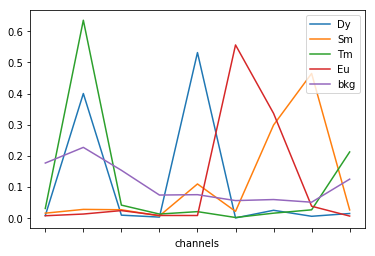

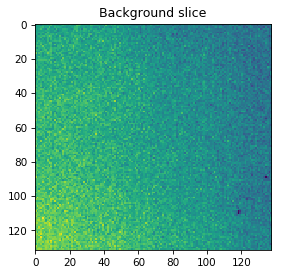

In [18]:
spec_object.plot()

## Spectral unmixing and get ratios

In [19]:
ratio_images = mrbles.Ratio(spec_object)

In [20]:
ratio_images.get(mrbles_images[:, :, DECODE_CHANNELS], 'Eu',  combine_data=mrbles_images[:, :, ['Cy5']])

c:\python36\lib\site-packages\xarray\core\dtypes.py:23: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

c:\python36\lib\site-packages\xarray\core\dtypes.py:25: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.

c:\python36\lib\site-packages\xarray\core\dtypes.py:29: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



In [21]:
ratio_images

{'A': <xarray.DataArray (f: 10, c: 9, y: 900, x: 900)>
array([[[[145, ..., 148],
         ...,
         [127, ..., 144]],

        ...,

        [[957.6173862365481, ..., 900.0949803155454],
         ...,
         [804.79330754574, ..., 1025.6726222181342]]],


       ...,


       [[[153, ..., 138],
         ...,
         [173, ..., 196]],

        ...,

        [[1019.2541647133219, ..., 935.1123367294188],
         ...,
         [880.2205502376337, ..., 825.2285294411716]]]], dtype=object)
Coordinates:
  * c        (c) object 'Cy5' 'Dy' 'Dy_ratio' 'Eu' 'Sm' 'Sm_ratio' 'Tm' ...
Dimensions without coordinates: f, y, x, 'B': <xarray.DataArray (f: 10, c: 9, y: 900, x: 900)>
array([[[[145, ..., 148],
         ...,
         [127, ..., 144]],

        ...,

        [[957.6173862365481, ..., 900.0949803155454],
         ...,
         [804.79330754574, ..., 1025.6726222181342]]],


       ...,


       [[[153, ..., 138],
         ...,
         [173, ..., 196]],

        ...,

        [[1019.

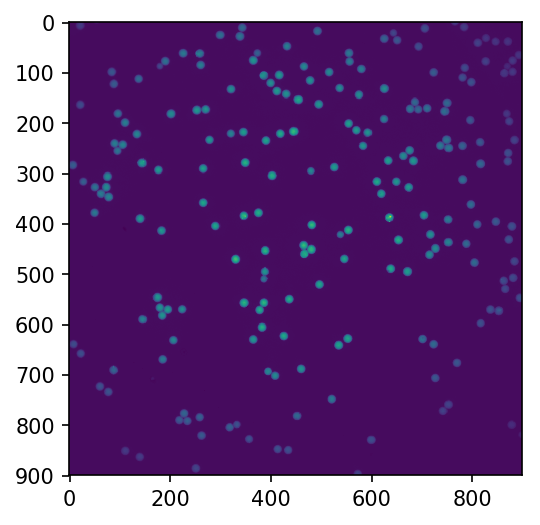

In [22]:
plt.figure(dpi=150)
plt.imshow(ratio_images['A', 5, 'Eu'].astype(float))

## Extract data from each MRBLE

In [23]:
extract_data = mrbles.Extract()

In [24]:
extract_data.get(ratio_images[:, :, ['Dy_ratio', 'Sm_ratio', 'Tm_ratio', 'bkg', 'Eu', 'Cy5']], 
                 find_mrbles[:, :, ['mask_ring', 'mask_inside', 'mask_full', 'mask_bkg']])

In [25]:
extract_data.filter(bkg_factor=2.0, ref_factor=2.0, bkg='bkg.mask_full', ref='Eu.mask_inside')

Pre-filter: 1654
Post-filter: 1578
Filtered: 76 (4.6%)


In [29]:
extract_data.data.to_csv(r"C:\Users\bjorn\OneDrive\Desktop\test.csv")

## Decode

In [ ]:
# Target file location
seq_file = pd.read_excel(r'C:\DATA\Huy\20180105_SEQ_CN_Final-Match-List.xlsx')
target = seq_file.loc[:, ['Dy', 'Sm', 'Tm']].values
sequences = seq_file.reset_index(drop=True)

In [ ]:
mrbles_decode = mrbles.Decode(target)
mrbles_decode.settings.icp._train = False

In [ ]:
bead_set = extract_data.data

In [ ]:
bead_set

In [ ]:
mrbles_decode.decode(bead_set.loc[:,('Dy_ratio.mask_inside', 'Sm_ratio.mask_inside', 'Tm_ratio.mask_inside')], combine_data=bead_set)

In [ ]:
mrbles_decode.data

In [ ]:
bead_set = mrbles_decode.data

confidence = 0.95

colors = np.multiply(bead_set[(bead_set.confidence > confidence)].code.values.astype(int), np.ceil(255/len(target)))

bead_ratios = go.Scatter3d(
    name='Bead ratios',
    x=bead_set.loc[(bead_set.confidence > confidence), ('Dy_ratio.mask_inside_icp')].values,
    y=bead_set.loc[(bead_set.confidence > confidence), ('Sm_ratio.mask_inside_icp')].values,
    z=bead_set.loc[(bead_set.confidence > confidence), ('Tm_ratio.mask_inside_icp')].values,
    text=bead_set.loc[(bead_set.confidence > confidence), ('code')].values + 1,
    mode='markers',
    marker=dict(
        size=3,
        color=colors, 
        colorscale='Rainbow',
        opacity=0.6
    )
)

target_ratios = go.Scatter3d(
    name='Target ratios',
    x=target[:,0],
    y=target[:,1],
    z=target[:,2],
    text=list(range(1, len(target)+1)),
    mode='markers',
    marker=dict(
        size=4,
        color='black',
        symbol="diamond"
    )
)

mean_ratios = go.Scatter3d(
    name='GMM mean ratios',
    x=mrbles_decode.settings.gmm.means[:,0],
    y=mrbles_decode.settings.gmm.means[:,1],
    z=mrbles_decode.settings.gmm.means[:,2],
    text=list(range(1, len(target)+1)),
    mode='markers',
    marker=dict(
        size=4,
        color='red',
        opacity=0.5,
        symbol="diamond"
    )
)

data = [bead_ratios, target_ratios, mean_ratios]
layout = go.Layout(
    showlegend=True,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)